In [1]:
#!pip install --no-index --upgrade pip

In [2]:
#!pip install --no-index tensorflow-gpu

In [3]:
#!pip install --no-index matplotlib

In [4]:
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from collections import Counter
from tensorflow.keras.models import Model
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

## Preprocessing: Tokenize, clean-up, load, padding

### Loading data 

In [6]:
# Load data
DIRECTORY_URL = "data/train/"
FILE_NAMES = ["train.lang1","train.lang2"]

In [7]:
decoder_input_text = []
decoder_target_text = []

with open(os.path.join(DIRECTORY_URL, FILE_NAMES[1]), 'r', encoding="UTF-8") as fr_file:
    for line in fr_file.readlines():
        line = line.rstrip().split('\n')

        target_line = line[0]+" <eos>"
        input_line = "<bos> "+line[0]

        decoder_input_text.append(input_line)
        decoder_target_text.append(target_line)
    fr_file.close()

In [8]:
decoder_input_text[0:3]

['<bos> L’ idée de concilier les différences religieuses semble donc dangereuse .',
 '<bos> Monsieur le Président , Mesdames et Messieurs , les perspectives financières esquissent la portée des activités de l’ UE pour les années à venir , fournissent un cadre pour ces activités et déterminent leur efficacité .',
 '<bos> La réticence doit laisser place à une politique stimulante .']

In [9]:
decoder_target_text[0:3]

['L’ idée de concilier les différences religieuses semble donc dangereuse . <eos>',
 'Monsieur le Président , Mesdames et Messieurs , les perspectives financières esquissent la portée des activités de l’ UE pour les années à venir , fournissent un cadre pour ces activités et déterminent leur efficacité . <eos>',
 'La réticence doit laisser place à une politique stimulante . <eos>']

In [10]:
encoder_input_text = []
with open(os.path.join(DIRECTORY_URL, FILE_NAMES[0]), 'r', encoding="UTF-8") as en_file:
    for line in en_file.readlines():
        line = line.rstrip().split('\n')
        encoder_input_text.append(line[0]+" .")
    en_file.close()

In [11]:
encoder_input_text[0:3]

['so too does the idea that accommodating religious differences is dangerous .',
 'mr president ladies and gentlemen the financial perspective outlines the scope of the eu ’s activities over coming years as well as providing a framework for such activities and determining how effective they will be .',
 'reserve should turn into thought - provoking policy .']

In [12]:
len(encoder_input_text), len(decoder_input_text), len(decoder_target_text)

(11000, 11000, 11000)

### Encoding the encoder input text

In [13]:
input_tokenizer = tf.keras.preprocessing.text.Tokenizer()
input_tokenizer.fit_on_texts(encoder_input_text)
input_integer_seq = input_tokenizer.texts_to_sequences(encoder_input_text)

word2idx_inputs = input_tokenizer.word_index
num_words_input = len(word2idx_inputs) + 1
print('Total unique words in the input: %s' % num_words_input)


max_input_len = max(len(sen) for sen in input_integer_seq)
print("Length of longest sentence in input: %g" % max_input_len)

Total unique words in the input: 13538
Length of longest sentence in input: 91


### Encoding the decoder input and target text

In [14]:
output_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
output_tokenizer.fit_on_texts(decoder_input_text + decoder_target_text)


output_integer_seq       = output_tokenizer.texts_to_sequences(decoder_target_text)
output_input_integer_seq = output_tokenizer.texts_to_sequences(decoder_input_text)

word2idx_outputs = output_tokenizer.word_index
num_words_output = len(word2idx_outputs) + 2
print('Total unique words in the output: %s' % num_words_output)


max_out_len = max(len(sen) for sen in output_integer_seq)
print("Length of longest sentence in the output: %g" % max_out_len)

Total unique words in the output: 17364
Length of longest sentence in the output: 113


### Statistics on data

In [15]:
en_sen_len = [len(x) for x in input_integer_seq]
fr_sen_len = [len(x) for x in output_integer_seq]

In [16]:
en_sequence_length = np.sort(np.unique(np.array(en_sen_len), return_counts=True),axis=1)
fr_sequence_length = np.sort(np.unique(np.array(fr_sen_len), return_counts=True),axis=1)

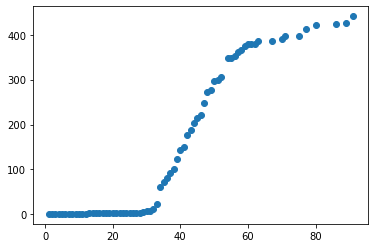

In [17]:
plt.scatter(en_sequence_length[0],en_sequence_length[1])

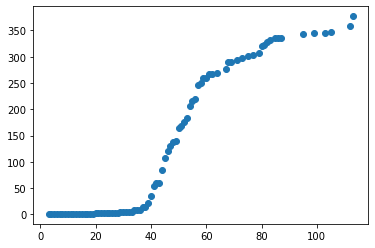

In [18]:
plt.scatter(fr_sequence_length[0],fr_sequence_length[1])

We notice here that french sentences are longer than english sentences, and hence the former used more tokens than the latter

### Reverse the input sequence

As described in Sutskever et al. 2013, they inversed the input senquence of the encoder to reduce the distance between its correspondant from decoder sequence.

In [19]:
reversed_sequence = [list(reversed(x)) for x in input_integer_seq]

In [20]:
input_integer_seq[0]

[42, 155, 118, 1, 338, 8, 7411, 966, 1366, 7, 823]

In [21]:
reversed_sequence[0]

[823, 7, 1366, 966, 7411, 8, 338, 1, 118, 155, 42]

### Padding

In [22]:
encoder_input_sequences = pad_sequences(input_integer_seq, maxlen=max_input_len)
print("encoder_input_sequences.shape:", encoder_input_sequences.shape)
print("encoder_input_sequences[0]:", encoder_input_sequences[0])

encoder_input_sequences.shape: (11000, 91)
encoder_input_sequences[0]: [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0   42  155  118    1
  338    8 7411  966 1366    7  823]


In [23]:
decoder_input_sequences = pad_sequences(output_input_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_input_sequences.shape:", decoder_input_sequences.shape)
print("decoder_input_sequences[0]:", decoder_input_sequences[0])

decoder_input_sequences.shape: (11000, 113)
decoder_input_sequences[0]: [   5   33  283    2 3485    9 1408 3053  358   85 4097    1    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]


In [24]:
decoder_output_sequences = pad_sequences(output_integer_seq, maxlen=max_out_len, padding='post')
print("decoder_output_sequences.shape:", decoder_output_sequences.shape)
print("decoder_output_sequences[0]:", decoder_output_sequences[0])

decoder_output_sequences.shape: (11000, 113)
decoder_output_sequences[0]: [  33  283    2 3485    9 1408 3053  358   85 4097    1    6    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]


### Preprocess the data

The following method wrapup all the previous steps, in order to simplify the execution

In [25]:
def preprocess_input_text(text, tokenizer, reverse=True):
    # Tokenize the data
    input_text = tokenizer.texts_to_sequences(text)
    
    # Reverse the sequence
    if reverse: input_text = [list(reversed(x)) for x in input_text]
    
    # Padding left side paddin='pre'
    input_padded = pad_sequences(input_text, maxlen=max_input_len, padding='pre')
    
    return input_padded

In [26]:
prep_input = preprocess_input_text(encoder_input_text, input_tokenizer)

In [27]:
prep_input[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,  823,    7, 1366,  966, 7411,    8,  338,    1,
        118,  155,   42])

In [28]:
# Sanity check
input_tokenizer.texts_to_sequences([encoder_input_text[0]])

[[42, 155, 118, 1, 338, 8, 7411, 966, 1366, 7, 823]]

In [29]:
def preprocess_output_text(text, tokenizer):
    
    # Encoding
    input_encoded = tokenizer.texts_to_sequences(text)
    
    # Padding
    input_padded = pad_sequences(input_encoded, maxlen=max_input_len, padding='post')
    
    return input_padded

### Define the seq2seq model

In [49]:
# configure problem
embedings_dim = 64
hidden_units = 512
LR = 0.0001
dropout = 0.5

In [50]:
#en_vocab_size, en_max_len, fr_vocab_size, fr_max_len, hidden_units, embedings_dim, LR

In [51]:
# Encoder
def seq2seq_model(num_en_tokens, embedings_dim, hidden_units, num_fr_tokens, max_input_len, max_out_len, LR, dropout):      
    
    encoder_inputs = layers.Input(shape=(None,))
    encoder_embeddings = layers.Embedding(num_en_tokens, embedings_dim, mask_zero=True)
    encoder_embedded = encoder_embeddings(encoder_inputs)
    encoder_bilstm = layers.Bidirectional(layers.LSTM(hidden_units, return_state=True, dropout=dropout))
    # Return states in addition to output
    output, forward_h, forward_c, backward_h, backward_c = encoder_bilstm(encoder_embedded)
    
    state_h = layers.Concatenate()([forward_h, backward_h])
    state_c = layers.Concatenate()([forward_c, backward_c])
    encoder_states = [state_h, state_c]
    
    #encoder_states = [forward_h, forward_c, backward_h, backward_c]

    # Decoder
    decoder_inputs = layers.Input(shape=(None, ))
    decoder_embeddings = layers.Embedding(num_fr_tokens, embedings_dim, mask_zero=True)
    decoder_embedded = decoder_embeddings(decoder_inputs)

    # Pass the 2 states to a new LSTM layer, as initial state
    decoder_lstm = layers.LSTM(hidden_units*2, return_sequences=True, return_state=True, dropout=dropout)
    decoder_outputs, _, _, = decoder_lstm(decoder_embedded, initial_state=encoder_states)

    decoder_dense = layers.Dense(num_fr_tokens, activation='linear')
    decoder_outputs = decoder_dense(decoder_outputs)

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=LR),
                  metrics=['accuracy'])
    model.summary()
    #SGD(learning_rate=0.2, decay=1e-4, momentum=0.9, nesterov=True), #
    
    # Evaluation model:
    encoder_model = Model(encoder_inputs, encoder_states)
    
    decoder_state_h = layers.Input(shape=(hidden_units*2,))
    decoder_state_c = layers.Input(shape=(hidden_units*2,))
    #decoder_state_b_h = layers.Input(shape=(hidden_units,))
    #decoder_state_b_c = layers.Input(shape=(hidden_units,))
    
    #e_state_h = layers.Concatenate()([decoder_state_f_h, decoder_state_b_h])
    #e_state_c = layers.Concatenate()([decoder_state_f_c, decoder_state_b_c])
    
    decoder_states_inputs = [decoder_state_h, decoder_state_c]#, decoder_state_b_h, decoder_state_b_c]
    
    decoder_inputs_single = layers.Input(shape=(1,))
    decoder_inputs_single_x = decoder_embeddings(decoder_inputs_single)
    decoder_outputs, h, c = decoder_lstm(decoder_inputs_single_x, initial_state=decoder_states_inputs)
    decoder_states = [h, c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model(
        [decoder_inputs_single] + decoder_states_inputs,
        [decoder_outputs] + decoder_states
    )
     
    
    return model, encoder_model, decoder_model

In [52]:
model, encoder_model, decoder_model = seq2seq_model(num_words_input, embedings_dim, hidden_units, num_words_output, max_input_len, max_out_len, LR, dropout)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, None, 64)     866432      input_6[0][0]                    
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
bidirectional_1 (Bidirectional) [(None, 1024), (None 2363392     embedding_2[0][0]                
____________________________________________________________________________________________

### Train the model

In [53]:
batch_size = 20
epochs=20

In [54]:
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath='BidirectionalLSTMv3.hdf5', verbose=2, save_best_only=True)

history = model.fit([encoder_input_sequences, decoder_input_sequences],
                            decoder_output_sequences,
                            batch_size=batch_size,
                            epochs=epochs, 
                            validation_split=0.2,
                            callbacks=[checkpointer])

Train on 8800 samples, validate on 2200 samples
Epoch 1/20
8780/8800 [============================>.] - ETA: 0s - loss: 1.4516 - accuracy: 0.0735
Epoch 00001: val_loss improved from inf to 1.38158, saving model to BidirectionalLSTMv3.hdf5
8800/8800 [==============================] - 200s 23ms/sample - loss: 1.4516 - accuracy: 0.0735 - val_loss: 1.3816 - val_accuracy: 0.0890
Epoch 2/20
8780/8800 [============================>.] - ETA: 0s - loss: 1.3249 - accuracy: 0.1036
Epoch 00002: val_loss improved from 1.38158 to 1.35180, saving model to BidirectionalLSTMv3.hdf5
8800/8800 [==============================] - 196s 22ms/sample - loss: 1.3243 - accuracy: 0.1037 - val_loss: 1.3518 - val_accuracy: 0.1175
Epoch 3/20
8780/8800 [============================>.] - ETA: 0s - loss: 1.2850 - accuracy: 0.1199
Epoch 00003: val_loss improved from 1.35180 to 1.32335, saving model to BidirectionalLSTMv3.hdf5
8800/8800 [==============================] - 195s 22ms/sample - loss: 1.2851 - accuracy: 0.1199

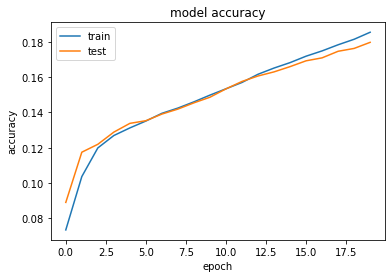

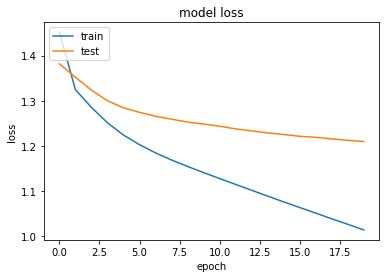

In [55]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [56]:
from tensorflow.keras.utils import plot_model
#plot_model(model, to_file = "seq2seq_translation.png", show_shapes = True)

## Evaluation

In [57]:
# load best weights
model.load_weights('BidirectionalLSTMv3.hdf5')

In [58]:
idx2word_input = {v:k for k, v in word2idx_inputs.items()}
idx2word_target = {v:k for k, v in word2idx_outputs.items()}

In [59]:
def translate_sentence(input_seq):
    
    # Preprocess input text
    input_seq = preprocess_input_text([input_seq], input_tokenizer)[0].reshape(-1,max_input_len)
    
    # Calculate encoder states value
    #print(input_seq)
    states_value = encoder_model.predict(input_seq)
    
    # Build special tokens
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = word2idx_outputs['<bos>']
    eos1 = word2idx_outputs['<eos>']
    eos2 = word2idx_outputs['.']
    output_sentence = []
    
    #print("Translating sequence: ", input_seq)
    for _ in range(max_out_len):
        #print("target_seq = ", target_seq)
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
        idx = np.argmax(output_tokens[0, 0, :])

        if ((eos1 == idx) or (eos2== idx)):
            break

        word = ''

        if idx > 0:
            word = idx2word_target[idx]
            output_sentence.append(word)
            #print("Predicting word "+word+"for index "+str(idx))

        target_seq[0, 0] = idx
        states_value = [h, c]
        
        

    return ' '.join(output_sentence)

In [60]:
target_text = []
with open(os.path.join(DIRECTORY_URL, FILE_NAMES[1]), 'r', encoding="UTF-8") as fr_file:
    for line in fr_file.readlines():
        line = line.rstrip().split('\n')
        target_text.append(line[0])
    fr_file.close()

In [61]:
np.random.seed(3)
ids = np.random.randint(0,100,10)

In [62]:
encoder_input_text[ids[0]], target_text[ids[0]]

("now let 's go to the visuals .", 'Maintenant , passons à la scénographie .')

In [63]:
targets = [target_text[i] for i in ids]
targets

['Maintenant , passons à la scénographie .',
 'Je suis intimement convaincu que nous ne pourrons progresser que si nous coopérons et négocions .',
 'Quels sports aimes - tu ?',
 "C' est pourquoi le lynchage de Kadhafi est de mauvais augure pour la Libye .",
 'L’ idée de concilier les différences religieuses semble donc dangereuse .',
 "Peut - elle indiquer si les inspecteurs agissaient en tant qu' inspecteurs de la NAFO ou en tant qu' inspecteurs du gouvernement canadien ?",
 "Le contexte humanitaire a profondément changé au cours des dernières années , d' où le besoin d' améliorer la capacité de réaction de l' UE .",
 "Au sujet de l' amendement 18 sur les pouvoirs d' enquête de la Commission , cette matière ne relève pas du règlement financier mais d' arrangements entre les institutions .",
 'Cette opportunité s’ appelle Barack Obama .',
 'Règlement appliquant un schéma de préférences tarifaires généralisées ( vote )']

In [64]:
predictions = []
for i in ids:
    translation = translate_sentence(encoder_input_text[i])

    print('Input:', encoder_input_text[i])
    print('------------------------------')
    print('Response:', translation)
    print('==============================')
    predictions.append(translation+'\n')

Input: now let 's go to the visuals .
------------------------------
Response: il est un chose
Input: it is my profound belief that we can only advance through cooperation and negotiation .
------------------------------
Response: il est donc que la commission de la commission de la commission de la commission
Input: what sports do you like .
------------------------------
Response: il est un chose
Input: this is why qaddafi ’s lynching party is a dangerous omen for libya .
------------------------------
Response: il est donc que les états membres , il est pas une question
Input: so too does the idea that accommodating religious differences is dangerous .
------------------------------
Response: il est donc que les question de la commission de la commission
Input: can it clarify whether the inspectors were acting on behalf of nafo or the canadian government .
------------------------------
Response: il est donc que les états membres , il est pas une situation de la commission
Input: th

In [65]:
with open("targets.txt", "w", encoding='utf-8') as target_file:
    target_file.writelines(target_text)
    target_file.close()

In [66]:
with open("predictions.txt", "w", encoding='utf-8') as target_file:
    target_file.writelines(predictions)
    target_file.close()

## SacreBLEU Evaluation 
['0.3', '0.2', '0.3', '0.2', '0.3', '']

final avg bleu score: 0.26